In [2]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Density Function

In [3]:
def p( x, t=1.0 ):
    return np.exp( -10*t*((x-2)**2) ) + 0.3*np.exp( -0.5*10*t*((x+1)**2) )

# Metropolis Hastings

In [14]:
variances = [0.1,1.0,10.0]
T = 10000

mhExplorationPath = np.zeros((3,3,T))

#  run all 3 variances
for i, var in enumerate(variances):
    #  run 3 runs for each variance
    for j in range(3):
        #  initialize and run T iterations of Metropolis-Hastings
        xt = 0
        for t in range(T):
            x = xt

            #  sample x' ~ q(x'|x)
            xprime = scp.random.normal(x, var)
            alpha = (p(xprime) * scp.random.normal(xprime, var)) / (p(x) * scp.random.normal(x, var))

            r = np.min([1, alpha])
            u = np.random.rand()

            if u < r:
                xt = xprime
            else:
                xt = xt
            mhExplorationPath[i][j][t] = xt

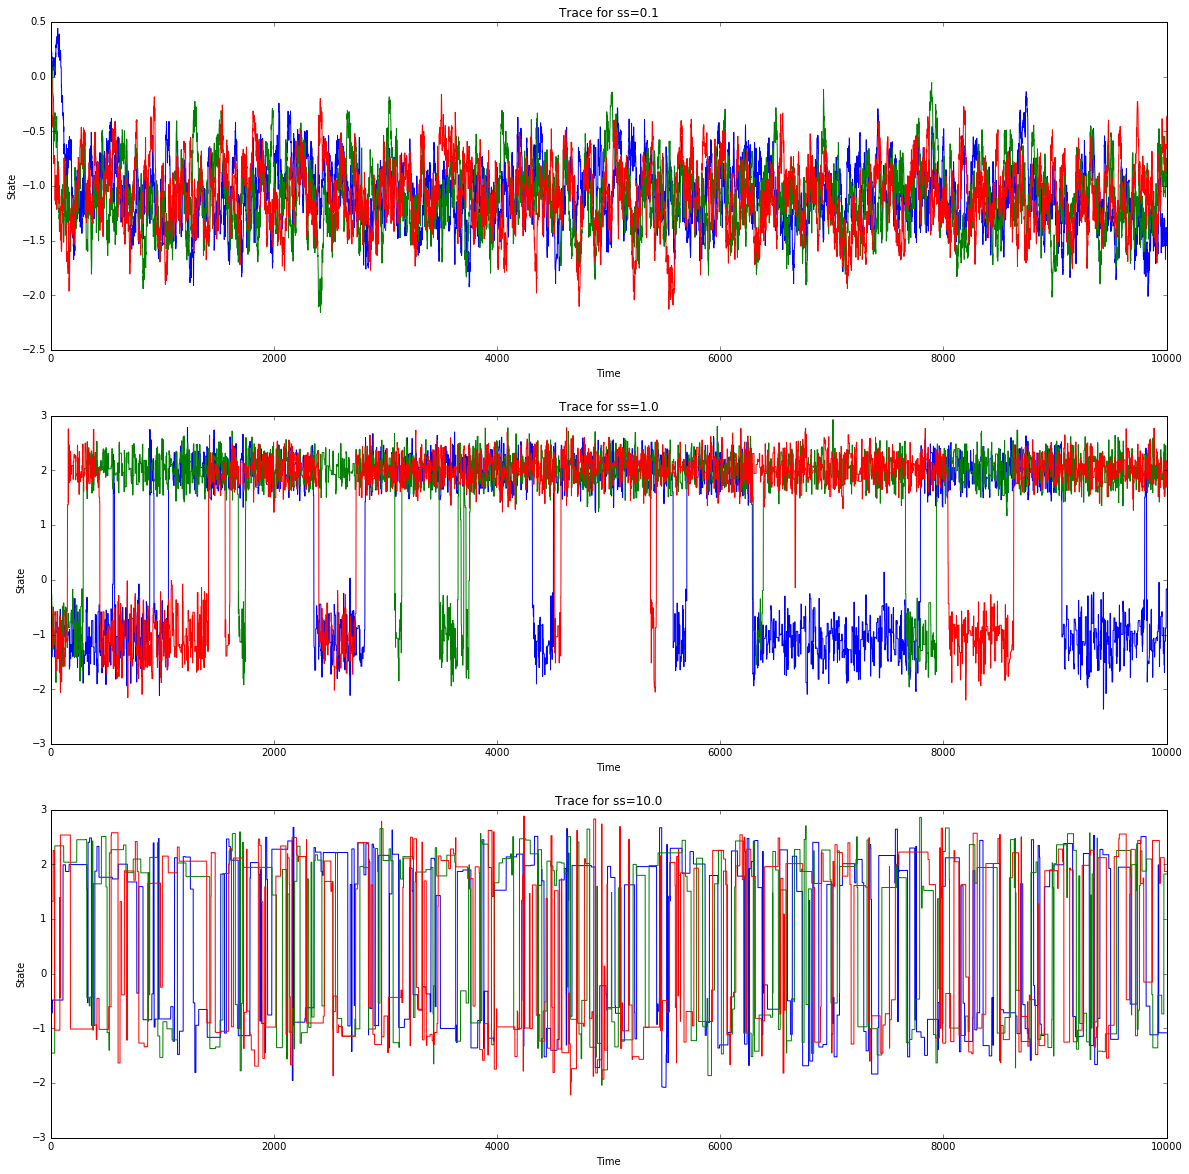

In [15]:
fig, ax = plt.subplots(3,1, figsize=(20,20))

ax[0].plot(mhExplorationPath[0][0])
ax[0].plot(mhExplorationPath[0][1])
ax[0].plot(mhExplorationPath[0][2])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("State")
ax[0].set_title("Trace for ss=0.1")



ax[1].plot(mhExplorationPath[1][0])
ax[1].plot(mhExplorationPath[1][1])
ax[1].plot(mhExplorationPath[1][2])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("State")
ax[1].set_title("Trace for ss=1.0")

ax[2].plot(mhExplorationPath[2][0])
ax[2].plot(mhExplorationPath[2][1])
ax[2].plot(mhExplorationPath[2][2])
ax[2].set_xlabel("Time")
ax[2].set_ylabel("State")
ax[2].set_title("Trace for ss=10.0")

In [16]:
plt

<module 'matplotlib.pyplot' from 'C:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

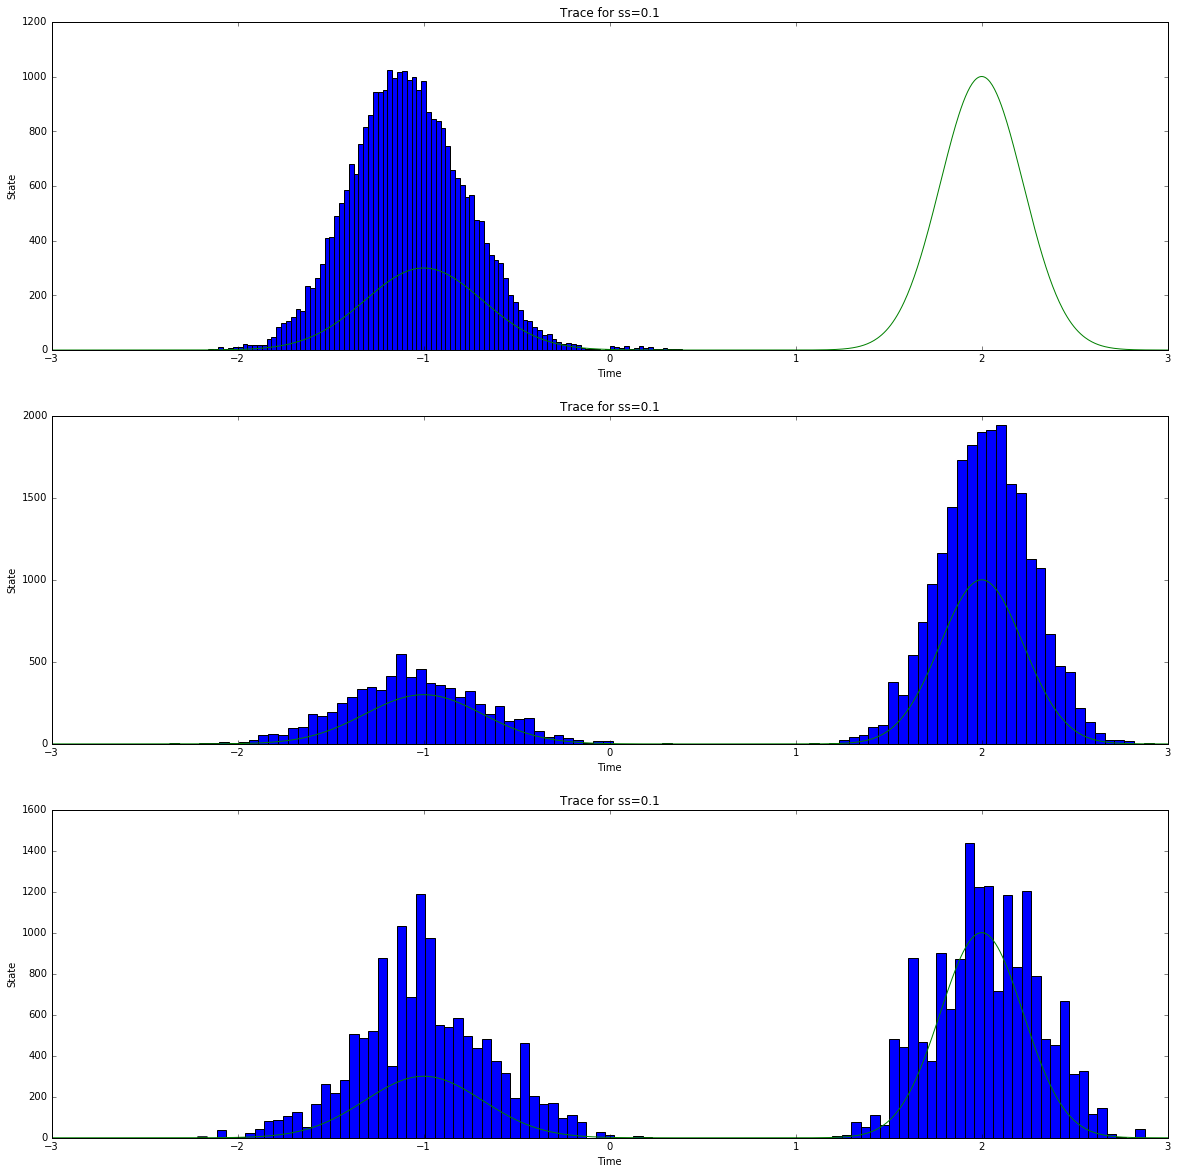

In [25]:
fig, ax = plt.subplots(3,1, figsize=(20,20))

plot1 = np.concatenate([np.concatenate([mhExplorationPath[0][0], mhExplorationPath[0][1]]),
                           mhExplorationPath[0][2]])
ax[0].hist(plot1, bins=100)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("State")
ax[0].set_title("Trace for ss=0.1")
ax[0].plot(np.linspace(-3,3,1000), p(np.linspace(-3,3,1000)) * 1000)


plot2 = np.concatenate([np.concatenate([mhExplorationPath[1][0], mhExplorationPath[1][1]]),
                           mhExplorationPath[1][2]])
ax[1].hist(plot2, bins=100)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("State")
ax[1].set_title("Trace for ss=0.1")
ax[1].plot(np.linspace(-3,3,1000), p(np.linspace(-3,3,1000)) * 1000)


plot3 = np.concatenate([np.concatenate([mhExplorationPath[2][0], mhExplorationPath[2][1]]),
                           mhExplorationPath[2][2]])
ax[2].hist(plot3, bins=100)
ax[2].set_xlabel("Time")
ax[2].set_ylabel("State")
ax[2].set_title("Trace for ss=0.1")
ax[2].plot(np.linspace(-3,3,1000), p(np.linspace(-3,3,1000)) * 1000)

# Hamiltonian MCMC

In [4]:
from autograd import grad
import autograd.numpy as np
grad_p = grad( p )
grad_p_vec = np.vectorize(grad_p)
p_vec = np.vectorize(p)

In [60]:
momentum_var_num = 1

def HMC (U, grad_U, epsilon, L, current_q):
#     import pdb
#     pdb.set_trace()
    
    
    q = current_q
    p = np.random.normal(0.0,1.0, 1) # independent standard normal variates
    current_p = p
    # Make a half step for momentum at the beginning
    p=p- epsilon * grad_U(q) / 2.0
    # Alternate full steps for position and momentum
    for i in range(1,L):
        # Make a full step for the position
        q=q+ epsilon * p
        # Make a full step for the momentum, except at end of trajectory
        if (i!=L):
            p=p- epsilon * grad_U(q)

    # Make a half step for momentum at the end.
    p=p- epsilon * grad_U(q) / 2.0
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = sum(current_p**2) / 2.0
#     current_K = (current_p**2) / 2.0

    proposed_U = U(q)
    proposed_K = sum(p**2) / 2.0
#     proposed_K = (p**2) / 2.0
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    if (np.random.uniform(0.0,1.3) < np.exp(current_U-proposed_U+current_K-proposed_K)):
        return q # accept
    else:
#         print("reject")
        return current_q # reject

    

In [66]:
tmp = []
current_sample = 0.0
for i in range(10000):
    print(i, end="\r")

    current_sample = HMC(p,grad_p, 0.1, 1, current_sample)
    tmp.append(current_sample)

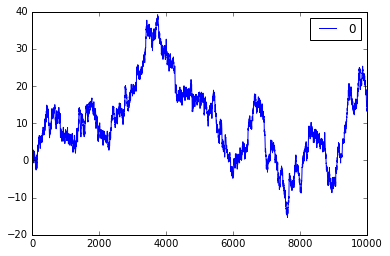

In [64]:
#  with 0.1 and 6
pd.DataFrame(tmp).plot(kind='line')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E4D01DD128>]], dtype=object)

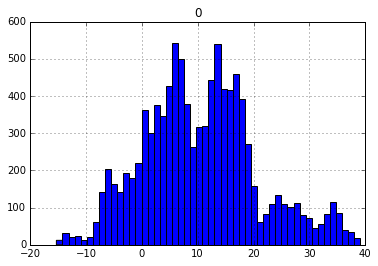

In [65]:
pd.DataFrame(tmp).hist(bins=50)

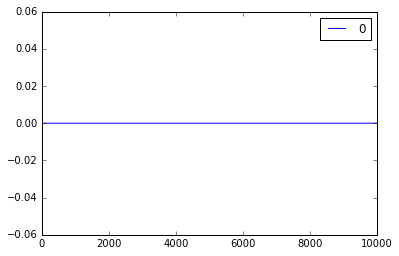

In [68]:
#  with 0.1 and 1
pd.DataFrame(tmp).plot(kind='line')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E4D0294898>]], dtype=object)

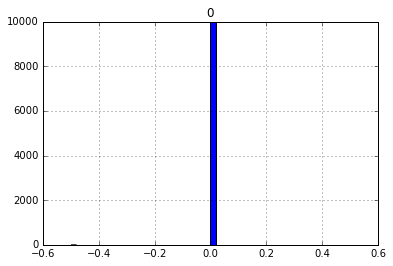

In [69]:
pd.DataFrame(tmp).hist(bins=50)

In [42]:
# variances = [0.1,0.5,2.0]
# steps = [2,5,10]
# T = 10000

# mhExplorationPath = np.zeros((3,3,T))

# hmc_parameter_exploration = []

# #  run all 3 variances
# for i, var_i in enumerate(variances):
#     #  run 3 runs for each variance
#     for j, step_j in enumerate(steps):
        

#         tmp = []
#         current_sample = 0.0
#         for i in range(10000):
#             print(i, end="\r")

#             current_sample = HMC(p,grad_p, var_i, step_j, current_sample)
#             tmp.append(current_sample)
#         hmc_parameter_exploration.append(tmp)
# #     print(type(current_sample))

In [44]:
# fig, ax = plt.subplots(9, figsize=(20,40))
# for i in range(3):
#     for j in range(3):
#             pd.DataFrame(mhExplorationPath[i][j]).plot(kind='line', ax=ax[i * 3 + j])
#             ax[i * 3 + j].set_title(str(i) + " " + str(j))
# #             pd.DataFrame(mhExplorationPath[i][j]).hist(bins=50, ax=ax[i * 3 + j + 1])




#  Results Writeup

#1 I don't have exact numbers but MH seemed to be near 50% while Hamiltonian MCMC seemed to have near 100%. I had a lot of trouble tuning HMC, either everything was accepted or nothing was.
#2 If the parameters aren't tuned correctly and the model isn't allowed to propose new positions far enough away then the model will never see any other modes that are sufficinetly far away. By allowing MH to look further with each proposal I let it finally discover the second mode of the density.
#3 If the parameters specify jumps that are far too large the the MCMC algorithm will reject almost 100% of the proposals it sees. This means it stays in one place for too long and gives that point too much weight in the final distribution. This is usually bad but is better then having a model that doesn't look far enough because these parameters can at least fine multiple modes that are far from each other.
#4 The best value for a variance of momentum was 0.1 in my findings while the best number of steps was 6. I really struggled with HMC though. It seemed like everything was implemented corrrect but I just couldn't for the life of me find a setting of the parameters which could help the model find both modes without traveling too far. The model either accepted everything or rejected everything so it was very weird and difficult. I knew that 0.1, and 6 where good because, if you look at the plots above this setting of the parameters produces the two largest spikes around where -1 and 2 should be. This indicates that the model is on the right track even if it's hasn't perfectly found the distribution yet.